In [66]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
train_path = os.path.join('datasets', 'titanic', 'train.csv')
test_path = os.path.join('datasets', 'titanic', 'test.csv')

train_df = pd.read_csv(train_path, index_col='PassengerId')
test_df = pd.read_csv(test_path, index_col='PassengerId')

print('Train size: ', train_df.shape)
print('Test size: ', test_df.shape)

train_df.head()

Train size:  (891, 11)
Test size:  (418, 10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


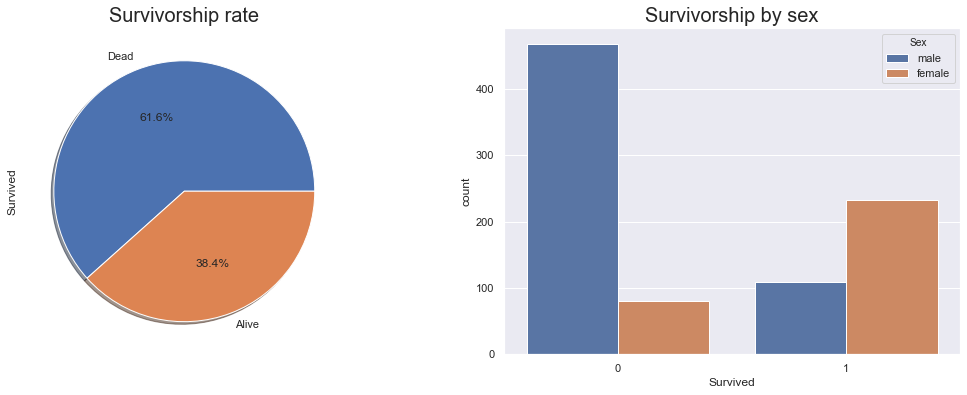

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
train_df['Survived'].value_counts().plot.pie(shadow=True, labels=['Dead', 'Alive'], autopct='%1.1f%%', ax=axes[0])
axes[0].set_title('Survivorship rate', fontsize=20)

sns.countplot(x='Survived', hue='Sex', data=train_df, ax=axes[1])
axes[1].set_title('Survivorship by sex', fontsize=20);

Unfortunately most people died. Out of 891 people in train data 61.6% people died. On titanic cruise there were more men than women. Suprisingly most people who survived were women. It shows that women had a priority during rescue. There were real gentlemen.

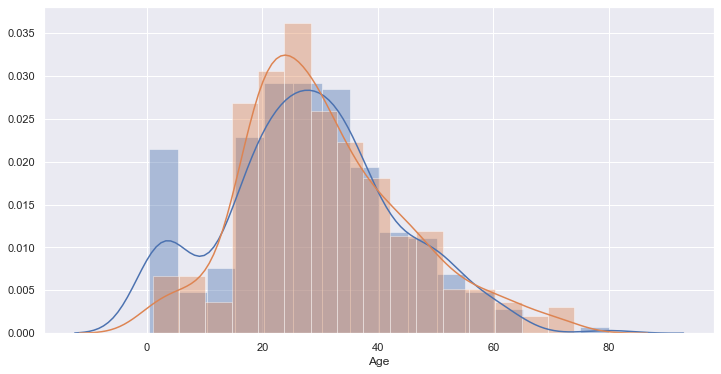

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

kde_kwargs={}

age_alive = train_df.loc[train_df['Survived'] == 1]
age_dead = train_df.loc[train_df['Survived'] == 0]

sns.distplot(age_alive['Age'], label='Alive', ax=ax, **kde_kwargs)
sns.distplot(age_dead['Age'], label='Dead', ax=ax, **kde_kwargs)

In [50]:
train_df['Age'].min()

0.42